In [11]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.utils import resample
from sklearn.metrics import silhouette_score, silhouette_samples

import matplotlib.cm as cm


Unificazione di tutti i file .csv in un'unica variabile data

In [2]:
# percorso base della cartella che contiene i CSV
base_dir = Path(
    r"C:\Users\nicde\OneDrive\Desktop\Università\Ancona\DS\Data-Science\datasets"
) / "MachineLearningCSV" / "MachineLearningCVE"

# elenco ordinato di tutti i file CSV
csv_files = sorted(base_dir.glob("*.csv"))

print(f"Numero di file CSV trovati: {len(csv_files)}")

dfs = []

# lettura sequenziale dei CSV
for i, file in enumerate(csv_files, 1):
    print(f"Caricamento file {i}/{len(csv_files)} → {file.name}")
    df = pd.read_csv(file, low_memory=False)
    #df["source_file"] = file.name   # tracciabilità (facoltativa ma utile)
    dfs.append(df)

# concatenazione row-wise
data = pd.concat(dfs, ignore_index=True)

# controlli rapidi
data.head()
#data.shape
#data.columns

Numero di file CSV trovati: 8
Caricamento file 1/8 → Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Caricamento file 2/8 → Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Caricamento file 3/8 → Friday-WorkingHours-Morning.pcap_ISCX.csv
Caricamento file 4/8 → Monday-WorkingHours.pcap_ISCX.csv
Caricamento file 5/8 → Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Caricamento file 6/8 → Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Caricamento file 7/8 → Tuesday-WorkingHours.pcap_ISCX.csv
Caricamento file 8/8 → Wednesday-workingHours.pcap_ISCX.csv


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Operazioni di pulizia del dataset come ad esempio, rimozione di spazi accidentali nei nomi delle colonne ed eliminazione delle righe con almeno un valore NaN

In [4]:
# Normalizzazione nomi colonne
data.columns = data.columns.str.strip()

# Pulizia sintattica Label (tenuta solo per valutazione ex post)
if "Label" in data.columns:
    data["Label"] = data["Label"].astype(str).str.strip()

# Colonne identificative o temporali non utili per EDA e ML
cols_to_drop = [
    "Flow ID",
    "Timestamp",
    "Src IP",
    "Dst IP",
    "Source IP",
    "Destination IP",
    "Src Port",
    "Dst Port",
    "Source Port",
    "Destination Port"
]

# Drop sicuro: elimina solo quelle effettivamente presenti
data.drop(columns=[c for c in cols_to_drop if c in data.columns],
          inplace=True)

# Separazione features e label
if "Label" in data.columns:
    y_label = data["Label"].copy()   # SOLO per analisi ex post
    X = data.drop(columns=["Label"])
else:
    y_label = None
    X = data.copy()

# Conversione forzata a numerico (NaN per errori)
X = X.apply(pd.to_numeric, errors="coerce")
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Sostituzione dei valori infiniti con NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Informazioni generali sul dataset
X.info()

# Colonne con più valori NaN
X.isna().sum(axis=0).sort_values(ascending=False).head(20)

# Rimozione delle osservazioni contenenti almeno un valore NaN
X = X.dropna(axis=0)

# Controllo finale dei NaN
X.isna().sum(axis=0).sort_values(ascending=False).head(10)

# Rimuove feature costanti
n_unique = X.nunique()
constant_cols = n_unique[n_unique == 1].index
print(f"Colonne costanti rimosse (varianza zero): {len(constant_cols)}")

# Elimina tali colonne
X = X.drop(columns=constant_cols)

# Scaling delle feature 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns
)

print("Shape finale feature matrix:", X_scaled.shape)
X_scaled.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 77 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                int64  
 1   Total Fwd Packets            int64  
 2   Total Backward Packets       int64  
 3   Total Length of Fwd Packets  int64  
 4   Total Length of Bwd Packets  int64  
 5   Fwd Packet Length Max        int64  
 6   Fwd Packet Length Min        int64  
 7   Fwd Packet Length Mean       float64
 8   Fwd Packet Length Std        float64
 9   Bwd Packet Length Max        int64  
 10  Bwd Packet Length Min        int64  
 11  Bwd Packet Length Mean       float64
 12  Bwd Packet Length Std        float64
 13  Flow Bytes/s                 float64
 14  Flow Packets/s               float64
 15  Flow IAT Mean                float64
 16  Flow IAT Std                 float64
 17  Flow IAT Max                 int64  
 18  Flow IAT Min                 int64  
 19  

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,-0.439612,-0.009825,-0.010426,-0.053793,-0.007145,-0.281253,-0.210906,-0.280686,-0.245193,-0.447694,...,-0.006947,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
1,-0.439609,-0.011158,-0.009424,-0.054393,-0.007143,-0.281253,-0.210906,-0.280686,-0.245193,-0.444613,...,-0.008518,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
2,-0.439611,-0.011158,-0.009424,-0.054393,-0.007143,-0.281253,-0.210906,-0.280686,-0.245193,-0.444613,...,-0.008518,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
3,-0.439612,-0.011158,-0.009424,-0.054393,-0.007143,-0.281253,-0.210906,-0.280686,-0.245193,-0.444613,...,-0.008518,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184
4,-0.439612,-0.009825,-0.010426,-0.053793,-0.007145,-0.281253,-0.210906,-0.280686,-0.245193,-0.447694,...,-0.006947,0.002547,-0.125799,-0.104619,-0.149404,-0.101068,-0.352126,-0.109516,-0.357072,-0.339184


ELBOW METHOD

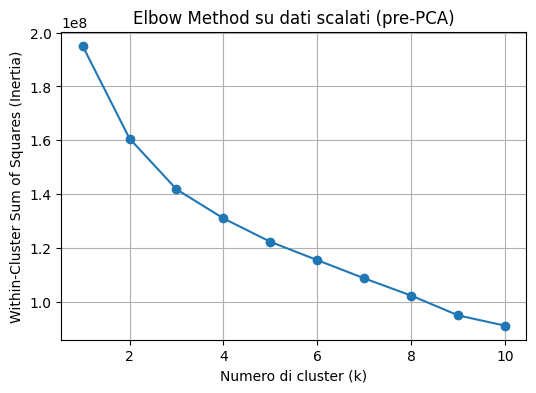

In [7]:
# Elbow Method per KMeans su dati scalati (pre-PCA)
distortions = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10      # stabilità della soluzione
    )
    kmeans.fit(X_scaled)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, distortions, marker='o')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method su dati scalati (pre-PCA)')
plt.grid(True)
plt.show()


KMEANS

In [8]:
kmeans = KMeans(n_clusters=3, random_state=0)
labels_kmeans = kmeans.fit_predict(X_scaled)

Silhouette Score medio (KMeans, spazio originale): 0.587


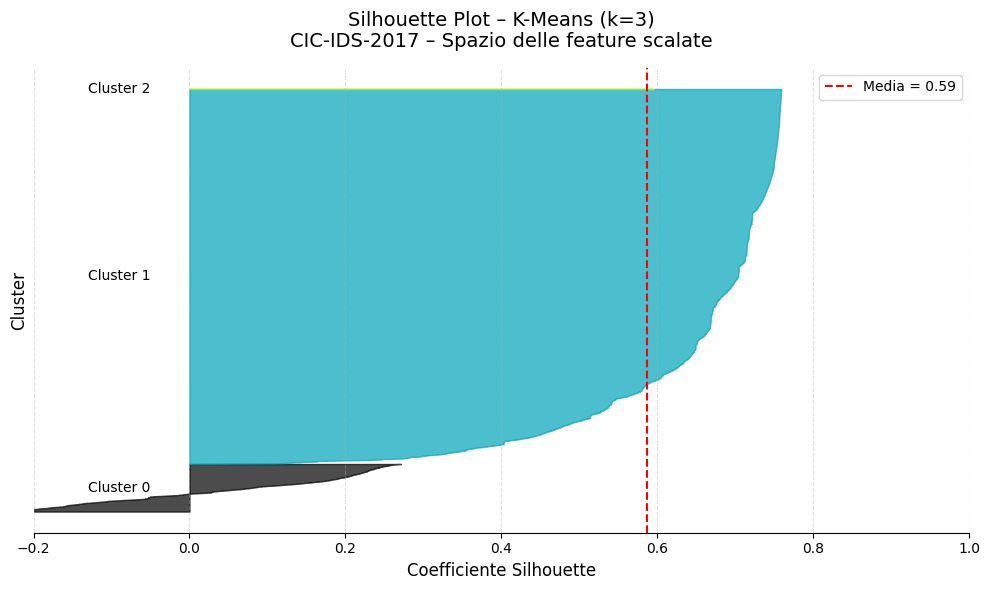

In [12]:
# Valutazione KMeans con silhouette score su dati scalati (pre-PCA)
# =========================
# Campionamento (necessario per dataset grandi)
# =========================
sample_size = min(100000, X_scaled.shape[0])

X_sampled, labels_sampled = resample(
    X_scaled,
    labels_kmeans,
    n_samples=sample_size,
    random_state=42
)

n_clusters = len(np.unique(labels_sampled))

# =========================
# Calcolo silhouette
# =========================
silhouette_avg = silhouette_score(X_sampled, labels_sampled)
silhouette_vals = silhouette_samples(X_sampled, labels_sampled)

print(f"Silhouette Score medio (KMeans, spazio originale): {silhouette_avg:.3f}")

# =========================
# Silhouette Plot
# =========================
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10

cmap = cm.nipy_spectral

for i in range(n_clusters):
    ith_cluster_silhouette_values = silhouette_vals[labels_sampled == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cmap(float(i) / n_clusters)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )

    ax.text(
        -0.05,
        y_lower + 0.5 * size_cluster_i,
        f"Cluster {i}",
        va="center",
        ha="right",
        fontsize=10
    )

    y_lower = y_upper + 10

# Linea della silhouette media
ax.axvline(
    x=silhouette_avg,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Media = {silhouette_avg:.2f}"
)

# =========================
# Formattazione grafico
# =========================
ax.set_title(
    "Silhouette Plot – K-Means (k=3)\nCIC-IDS-2017 – Spazio delle feature scalate",
    fontsize=14,
    pad=15
)
ax.set_xlabel("Coefficiente Silhouette", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)

ax.set_xlim([-0.2, 1.0])
ax.set_yticks([])
ax.grid(axis="x", linestyle="--", alpha=0.4)

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

